# DELETWEET DELETION TIMES

***

In [1]:
import json
import nltk
import pandas
import matplotlib
from datetime import datetime
from matplotlib import pyplot as plt
from nltk.tokenize import TweetTokenizer

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [18.0, 12.0]

***
## *PARSE DATA*

The Politwoops dataset came with two fields, 'created' and 'modified', that contain information about how long the tweet was live before it was deleted. The 'created' field corresponds to the time the tweet was originally created, whereas the 'modified' field corresponds to the last modification made to the tweet, which in this case is when it was deleted. To determine the time the tweet was live we take a simple difference between the two fields.

To achieve this we import the data and convert the two relevant fields into datetime objects, which allows for easy subtraction in python. Then we add a new column to our dataframe that represents the difference between the two.

In [2]:
# import dataset
deletweet = pandas.read_csv('../../deletweet/data/deleted_tweets_cleaned.csv')

In [3]:
# convert time fields in dataframe to datetime objects for easier analysis
deletweet['created'] = pandas.to_datetime(deletweet['created'])
deletweet['modified'] = pandas.to_datetime(deletweet['modified'])

In [4]:
# add new column to dataframe for the time difference from tweet creation to deletion
deletweet['time_diff'] = deletweet['modified'] - deletweet['created']

***
## *PLOT AND ANALYSIS*

Two different papers on tweet analysis ([here](http://www.cs.cmu.edu/~bliu1/Hazim_Almuhimedi_CSCW2013_Tweets.pdf) and [here](http://www2016.net/proceedings/proceedings/p603.pdf)) task themselves with determining for what reason a tweet has been deleted, based on the tweet's content and metadata. Both of them find that tweets that are deleted soon after their creation - as in a matter of seconds to several hours - are overwhelmingly deleted for aesthetic reasons, such as misspellings, improper formatting, broken or misdirected links, etc. They go on to say that tweets that are live several hours or more before being deleted are more likely to be classified as 'regrettable', and that anywhere from two hours to ten hours can be the threshold or decision boundary between regrettable and aesthetic.

The reasons for regret are varied, and determining them and their influence on decision making is a deeply philosophical question. However, given that this set of tweets is political in nature, it is safe to assume that they are likely to be in service of forming and supporting a positive public image for the politicians. In this context, regret can be more clearly expressed as a response to a tweet that is perceived as doing harm to this image or public opinion. While this is something to keep in mind, we will see below that it proves difficult to discern concrete differences that indicate that tweets deleted after 10 hours are more regrettable.

A look at the basic statistics of the 'time_diff' field show that the time for deletion varies greatly, from essentially instantly to over 5 years later. However the 50th percentile is only about 8 minutes, which means that over half the tweets have most likely been deleted for aesthetic reasons.

In [5]:
deletweet['time_diff'].describe()

count                       67756
mean      97 days 08:50:35.898990
std      246 days 15:10:23.122675
min               0 days 00:00:00
25%        0 days 00:00:33.750000
50%               0 days 00:07:54
75%       19 days 21:19:45.750000
max            1888 days 02:34:13
Name: time_diff, dtype: object

In [6]:
# make pandas series of time_diff column expressed as seconds for plotting
seconds = pandas.Series([deletweet['time_diff'][i].seconds for i in range(len(deletweet))], index=[deletweet['id'][i] for i in range(len(deletweet))])
seconds_sorted = sorted(seconds)

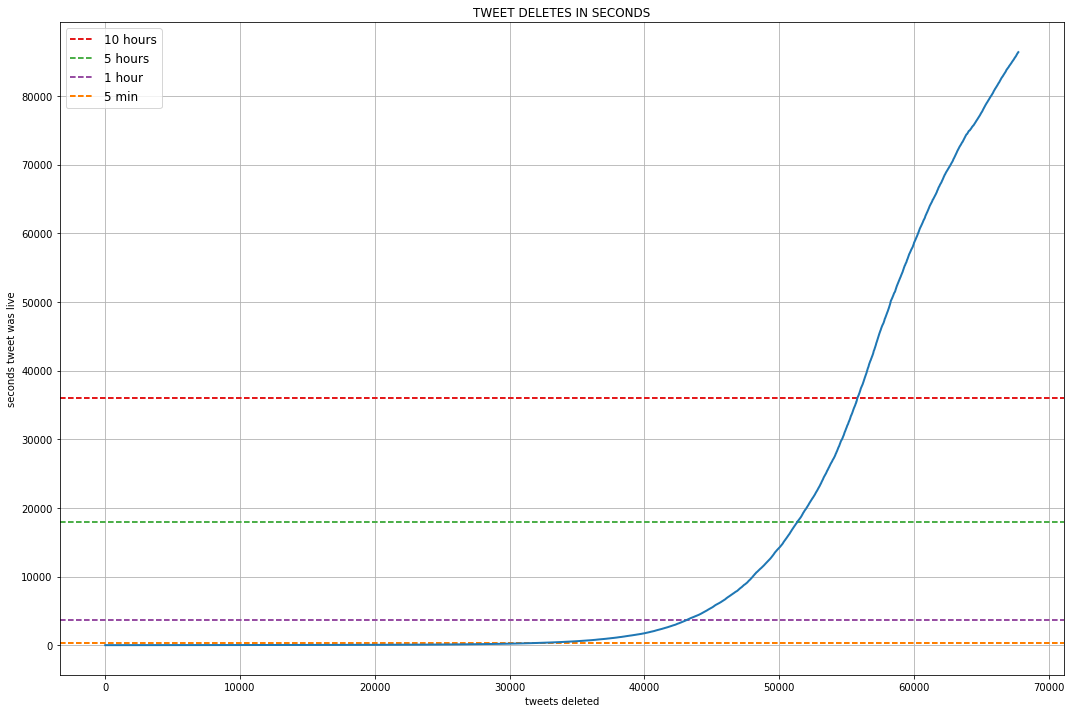

In [7]:
plt.figure()
plt.title('TWEET DELETES IN SECONDS')
plt.xlabel('tweets deleted')
plt.ylabel('seconds tweet was live')
plt.grid(True)
plt.yticks([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000])
plt.axhline(y=36000, linewidth=2, color = '#e41a1c', linestyle='dashed', label='10 hours')
plt.axhline(y=18000, linewidth=2, color = '#4daf4a', linestyle='dashed', label='5 hours')
plt.axhline(y=3600, linewidth=2, color = '#984ea3', linestyle='dashed', label='1 hour')
plt.axhline(y=300, linewidth=2, color = '#ff7f00', linestyle='dashed', label='5 min')
plt.legend(prop={'size':12})
plt.plot(seconds_sorted, linewidth=2)

In [8]:
# make buckets to sort by time tweet was live before being deleted
times = {'0-5 min': 300, '1-2 hrs': 7200, '15-30 min': 1800, '2-5 hrs': 18000, '30 min - 1 hr': 3600, '5-10 hrs': 36000, '5-15 min': 900, '>10hrs': 36000}
times_list = ['0-5 min', '5-15 min', '15-30 min', '30 min - 1 hr', '1-2 hrs', '2-5 hrs', '5-10 hrs', '>10hrs']

grouped = {key: [] for key in times.keys()}

for tweet in seconds.iteritems():
    if tweet[1] <= times['0-5 min']:
        grouped['0-5 min'].append(tweet[0])
    elif tweet[1] <= times['5-15 min'] and tweet[1] > times['0-5 min']:
        grouped['5-15 min'].append(tweet[0])
    elif tweet[1] <= times['15-30 min'] and tweet[1] > times['5-15 min']:
        grouped['15-30 min'].append(tweet[0])
    elif tweet[1] <= times['30 min - 1 hr'] and tweet[1] > times['15-30 min']:
        grouped['30 min - 1 hr'].append(tweet[0])
    elif tweet[1] <= times['1-2 hrs'] and tweet[1] > times['30 min - 1 hr']:
        grouped['1-2 hrs'].append(tweet[0])
    elif tweet[1] <= times['2-5 hrs'] and tweet[1] > times['1-2 hrs']:
        grouped['2-5 hrs'].append(tweet[0])
    elif tweet[1] <= times['5-10 hrs'] and tweet[1] > times['2-5 hrs']:
        grouped['5-10 hrs'].append(tweet[0])
    elif tweet[1] > times['5-10 hrs']:
        grouped['>10hrs'].append(tweet[0])

In [9]:
# print number of tweets in each timeframe
for time in times_list:
    print('{:,}: {}'.format(len(grouped[time]), time))

31,723: 0-5 min
5,282: 5-15 min
3,160: 15-30 min
2,917: 30 min - 1 hr
3,280: 1-2 hrs
5,012: 2-5 hrs
4,441: 5-10 hrs
11,941: >10hrs


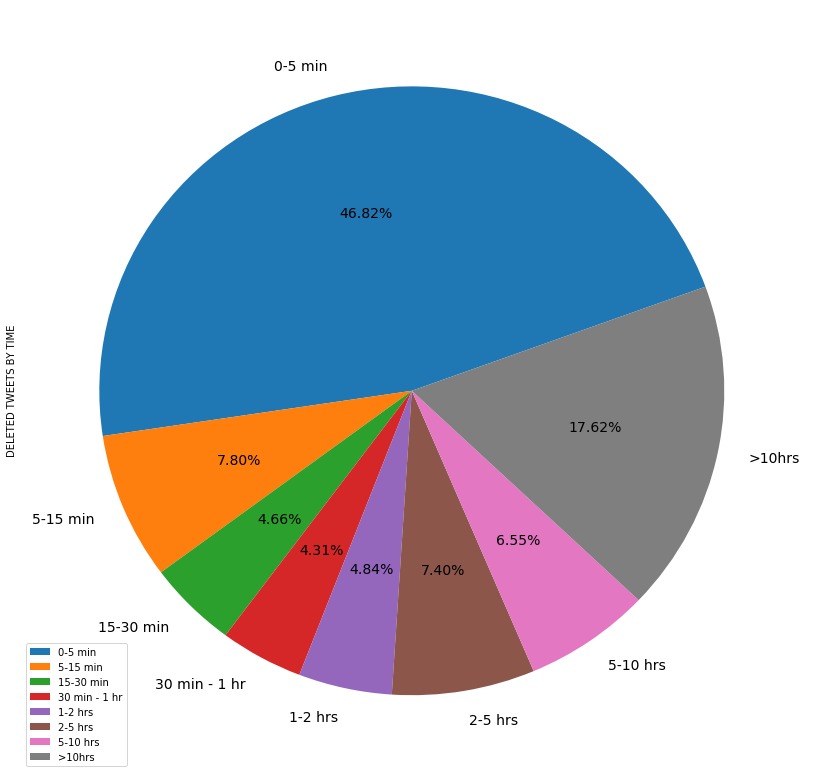

In [10]:
# transform into pandas series for plotting
tweet_series = pandas.Series([len(grouped[times_list[i]]) for i in range(len(grouped))], index=times_list, name='DELETED TWEETS BY TIME')
tweet_series.plot.pie(figsize=(14, 14), fontsize=14, autopct='%.2f%%', startangle=20, legend=True)

The graphs above indicate that close to half the tweets are deleted within 5 minutes of posting, and that almost 70% are deleted within 1 hour of posting. This is a good indication that the majority of this dataset is likely to have been deleted for aesthetic reasons.

***
## *SUBSETTING TWEETS DELETED AFTER 10 HOURS*

In [11]:
# ids of the tweets that were deleted after 10 or more hours
subset_ids = grouped['>10hrs']

In [12]:
# construct a list of strings to hold the tweet text
tweet_text_raw = []

for thing in deletweet['id'].iteritems():
    if thing[1] in subset_ids:
        tweet_text_raw.append(deletweet['content'][thing[0]])

In [13]:
# number of tweets in the 10+ hour subset
len(tweet_text_raw)

11941

In [14]:
# subset's % of total
print('{:.2%}'.format(len(tweet_text_raw) / len(deletweet)))

17.62%


In [15]:
# find number of retweets in the subset
retweet_count = 0

for thing in deletweet['id'].iteritems():
    if thing[1] in subset_ids:
        tweet = json.loads(deletweet['tweet'][thing[0]])
        if 'retweeted_status' in tweet.keys():
            retweet_count += 1

print('{:,}'.format(retweet_count))

4,826


In [16]:
# retweets as percentage of total tweets in 10+ hour subset
print('{:.2%}'.format(retweet_count / len(subset_ids)))

40.42%


Interestingly 40.42% of this subset consists of retweets, which is much higher than the original dataset's retweet percentage of 23.5%.

***
## *CONTENT ANALYSIS OF 10+ HOUR SUBSET*

In [17]:
# tokenize with NLTK's tweet tokenizer and convert to NLTK text object
tweet_string = ' '.join(tweet_text_raw)

tknzr = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
tweet_tokenized = tknzr.tokenize(tweet_string)

text = nltk.Text(tweet_tokenized)

In [18]:
# remove stopwords, punctuation
stopwords = nltk.corpus.stopwords.words('english')
punctuation_etc = ['.', ':', ',', '!', '"', '-', '…', '...', "’", '?', '/', "'", '(', ')', '“', '”', '&', '%']
filtered = [w for w in tweet_tokenized if w.lower() not in stopwords]
filtered = [w for w in filtered if w.lower() not in punctuation_etc]

processed = []

# remove numbers
for i in range(len(filtered)):
    try:
        float(filtered[i])
    except ValueError:
        processed.append(filtered[i])


text_normalized = nltk.Text(processed)

In [19]:
# percentage of text remaining after normalizing
print('{:.2%}'.format(len(text_normalized) / len(text)))

55.89%


In [20]:
words_normalized = [w.lower() for w in text_normalized]
vocab_normalized = sorted(set(words_normalized))

# of unique words in normalized text
len(vocab_normalized)

25146

In [21]:
# lexical diversity
print('{:.2%}'.format(len(vocab_normalized) / len(words_normalized)))

20.99%


In [22]:
# top 50 bigrams that frequently occur together
text_normalized.collocations(50)

added video; video playlist; #tg4lg #jobsnow; #mtsen #mtpol; looking
forward; #azgov #ducey2014; health care; hansen clarke; common sense;
renee ellmers; middle class; make sure; early voting; john mica;
colbert busch; president obama; last night; doug collins; town hall;
photo facebook; good luck; student loan; high school; little rock;
spread word; #flipadistrict #fl07; posted new; #ar2 #argop; #txsen
#ibleedtx; mike waite; minimum wage; tea party; http://t . ...; small
business; phone bank; don't forget; thoughts prayers; chamber
commerce; wall street; election day; new photo; south carolina; great
time; #betterknowachallenger #fl7; #colbertbump
#betterknowachallenger; midnight momentum; hard work; it's time; fox
news; monday midnight


In [23]:
# 50 most common words
fdist = nltk.FreqDist(text_normalized)
common = fdist.most_common(50)
pandas.Series([common[i][1] for i in range(len(common))], index=[common[i][0] for i in range(len(common))])

rt             5265
today           906
great           645
support         499
vote            498
thank           437
thanks          436
us              431
$               419
time            403
w               392
day             391
new             376
get             372
rep             369
help            360
house           337
congress        315
#tg4lg          313
http            311
tonight         304
need            278
#nc02           271
join            270
bill            268
people          262
video           262
obama           260
#ia03           250
county          241
i'm             240
please          234
work            230
make            219
campaign        218
proud           217
good            213
see             213
president       204
tomorrow        200
congressman     199
it's            198
one             191
jobs            187
first           185
#obamacare      185
via             183
watch           182
state           181
women           179


In [24]:
# words longer than 4 characters occurring more than 100 times
for frequent in sorted(word for word in set(text) if len(word) > 4 and fdist[word] > 100):
    print(frequent)

#ia03
#jobsnow
#nc02
#obamacare
#tg4lg
#txsen
added
america
american
better
budget
campaign
check
collins
congress
congressional
congressman
country
county
district
don't
election
ellmers
families
family
first
follow
friends
great
happy
health
honored
house
let's
meeting
morning
national
obama
office
people
playlist
please
president
proud
rehberg
right
senate
service
stand
state
support
talking
thank
thanks
today
tomorrow
tonight
veterans
video
voted
voting
washington
watch
women
working
would
years


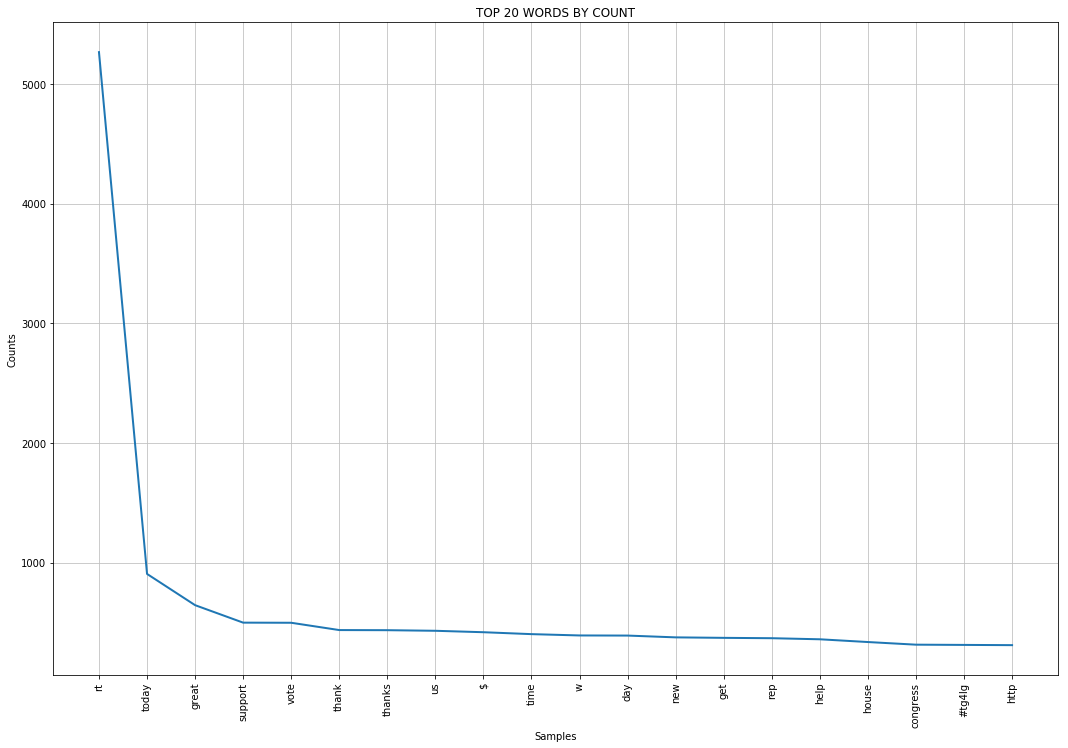

In [25]:
# plot frequencies of top 20 words
fdist.plot(20, title='TOP 20 WORDS BY COUNT')

In [26]:
# calculate 'rt's percentage of normalized text
print('{:.2%}'.format(fdist.freq('rt')))

4.39%


After analysis of the text, it appears difficult to classify the tweets that were deleted after 10 hours as more or less regrettable than the rest of the dataset. The content analysis of the subset is largely similar to that of the whole dataset, although there are some differences that are worth noting.

One area of difference is the collocations, or the frequently occuring bigrams. The presence of phrases such as 'added video', 'video playlist', 'photo facebook', 'new photo, 'last night', 'midgnight momentum', and 'fox news' may be indicative of tweets that contained content that was later determined to be regrettable. Also the presence of certain names may indicate that those people were at the center of contested issues, and tweets posted related to them may be contentious enough to be later deleted.

Another notable difference is the more frequent occurence of the hashtag '#obamacare', which is undoubtedly the subject of intense debate, and tweets that mention it may be subject to deletion based on response to the tweet, or potential harm done to the general constituency's perception of the politician.

***
## *MOST COMMON DELETION TIMES*

Here we sort the tweets into buckets based on the hour and day they were created and deleted. We do this for both the entire dataset, and the subset of tweets deleted after 10 hours. There is little substantial difference between the distributions of the whole dataset and the subset.

Tweets in this dataset are overwhelming authored and deleted between the hours of 12PM - 1AM. The similarity between the range of the day that they are both created and deleted would seem to suggest that these are the hours that politicians are likely to be active on Twitter, rather than suggesting that tweets that are later deemed regrettable (for aesthetic reasons or otherwise) are likely to be authored at a particular time of day.

The same can be said for day of the week: tweets are likely to be authored and deleted Monday through Friday (0-5 on the x-axis), which corresponds to the traditional American work week.

In [27]:
# sort tweets by hour and day they were created
created_hours = {i: [] for i in range(24)}
created_days = {i: [] for i in range(7)}

for i in range(len(deletweet)):
    created_hours[deletweet['created'][i].hour].append(deletweet['id'][i])
    created_days[deletweet['created'][i].weekday()].append(deletweet['id'][i])

In [28]:
# do the same for the 10+ hour subset
created_hours_subset = {i: [] for i in range(24)}
created_days_subset = {i: [] for i in range(7)}

for i in range(len(deletweet)):
    if deletweet['id'][i] in subset_ids:
        created_hours_subset[deletweet['created'][i].hour].append(deletweet['id'][i])
        created_days_subset[deletweet['created'][i].weekday()].append(deletweet['id'][i])

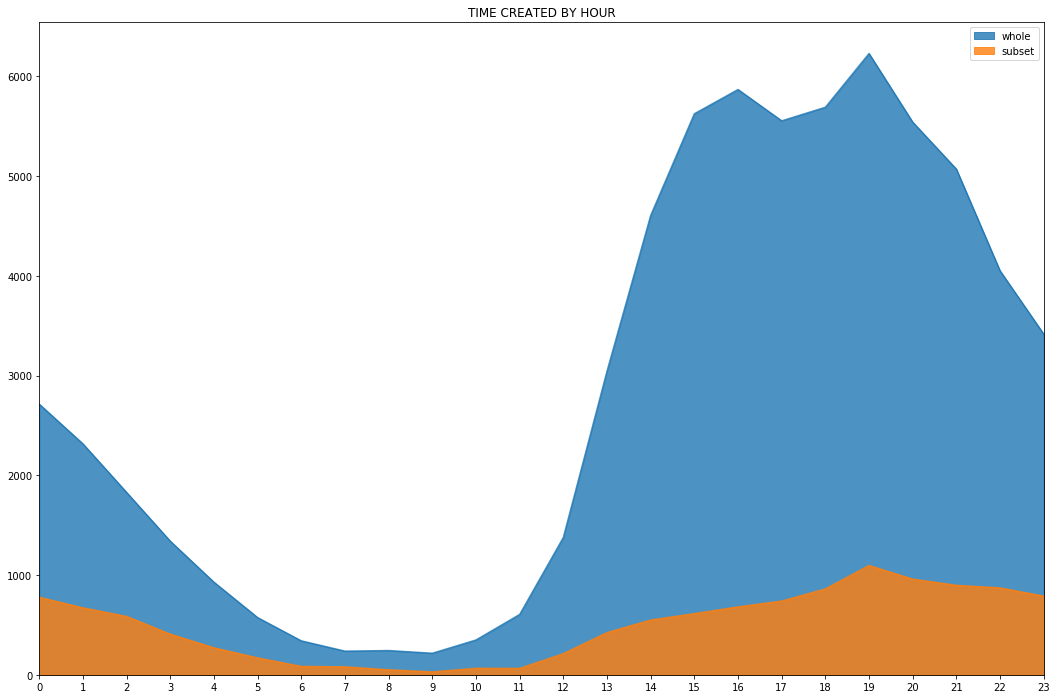

In [29]:
# create dataframes from hourly data for plotting
df_created_hours = pandas.DataFrame([len(created_hours[i]) for i in range(24)], columns=['whole'])
df_created_hours['subset'] = pandas.Series([len(created_hours_subset[i]) for i in range(24)])
df_created_hours.plot.area(stacked=False, title='TIME CREATED BY HOUR', xticks=[i for i in range(24)], alpha=0.8)

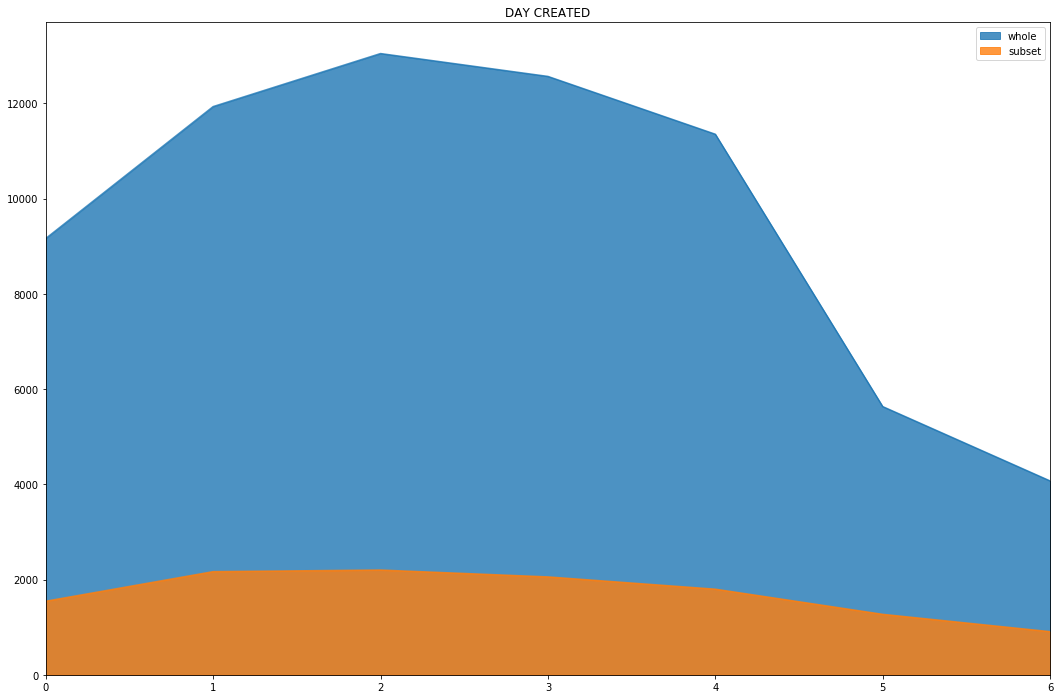

In [30]:
# create dataframes from daily data for plotting
df_created_days = pandas.DataFrame([len(created_days[i]) for i in range(7)], columns=['whole'])
df_created_days['subset'] = pandas.Series([len(created_days_subset[i]) for i in range(7)])
df_created_days.plot.area(stacked=False, title='DAY CREATED', xticks=[i for i in range(7)], alpha=0.8)

In [ ]:
# sort tweets by hour and day they were deleted
deleted_hours = {i: [] for i in range(24)}
deleted_days = {i: [] for i in range(7)}

for i in range(len(deletweet)):
    deleted_hours[deletweet['modified'][i].hour].append(deletweet['id'][i])
    deleted_days[deletweet['modified'][i].weekday()].append(deletweet['id'][i])

In [ ]:
# do the same for the 10+ hour subset
deleted_hours_subset = {i: [] for i in range(24)}
deleted_days_subset = {i: [] for i in range(7)}

for i in range(len(deletweet)):
    if deletweet['id'][i] in subset_ids:
        deleted_hours_subset[deletweet['modified'][i].hour].append(deletweet['id'][i])
        deleted_days_subset[deletweet['modified'][i].weekday()].append(deletweet['id'][i])

In [ ]:
# create dataframes from hourly data for plotting
df_deleted_hours = pandas.DataFrame([len(deleted_hours[i]) for i in range(24)], columns=['whole'])
df_deleted_hours['subset'] = pandas.Series([len(deleted_hours_subset[i]) for i in range(24)])
df_deleted_hours.plot.area(stacked=False, title='DELETED BY HOUR', xticks=[i for i in range(24)], alpha=0.8)

In [ ]:
# create dataframes from daily data for plotting
df_deleted_days = pandas.DataFrame([len(deleted_days[i]) for i in range(7)], columns=['whole'])
df_deleted_days['subset'] = pandas.Series([len(deleted_days_subset[i]) for i in range(7)])
df_deleted_days.plot.area(stacked=False, title='DELETED BY DAY', xticks=[i for i in range(7)], alpha=0.8)

***
## *CONCLUSION*

It is difficult to extract concrete differences between the entire dataset and the subset of tweets that were deleted after 10+ hours, which are those that have more potential to be regrettable for reasons other than aesthetics. While there are some minor differences in common content between the datasets, it is clear that the vast majority of the tweets in the Politwoops dataset are likely deleted for aesthetic reasons such as misspellings, rather than the tweets being hotly contested, or damaging to the author's reputation or public image.

The most common times for both creation and deletion of tweets in this dataset are Monday - Friday